# Extract tissue/lineage & prepare input for scVelo, which is Python-based

#### Working directory should contain root atlas Seurat object, which is available on GEO under record GSE152766:

    Root_Atlas.rds (or get it by running through notebook 2, 3, 4, 5 & 6)
    Root_Atlas_spliced_unspliced_raw_counts.rds

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
# Load libraries
suppressMessages(library(Seurat))
suppressMessages(library(CytoTRACE))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggplot2))
suppressMessages(library(grid))

In [3]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu314/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_3.3.1      RColorBrewer_1.1-2 CytoTRACE_0.1.0    Seurat_3.1.5      

loaded via a namespace (and not attached):
 [1] httr_1.4.1         tidyr_1.1.0        jsonlite_1.6.1     viridisLite_0.3.0 
 [5] splines_3.6.1      leiden_0.3.3       ggrepel_0.8.2      globals_0.12

In [11]:
# Plotting function for cell tyepes and time zone
plot_anno <- function(rc.integrated){
order <- c("Putative Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium", "Unknown")
palette <- c("#9400D3","#dcd0ff", "#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#ff9900","#e6194b", "#9a6324", "#ffe119","#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno", order = c("Maturation","Elongation","Meristem"),cols = c("#DCEDC8", "#42B3D5", "#1A237E"))
options(repr.plot.width=20, repr.plot.height=8)
gl <- lapply(list(p1, p2), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)
}

In [5]:
# Read in atlas
rc.integrated <- readRDS('./Root_Atlas.rds')
rc.su.counts <- readRDS('./Root_Atlas_spliced_unspliced_raw_counts.rds')

## 1. Extract Ground Tissue

In [6]:
# Index for ground tissue trajectory
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Endodermis" | rc.integrated$celltype.anno == "Cortex" | rc.integrated$celltype.anno == "Putative Quiescent Center"| rc.integrated$celltype.anno == "Stem Cell Niche") 

In [7]:
# Extract ground tissue
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])

In [12]:
# Run UMAP
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 50)
end.cor.integrated@reductions$umap_50 <- end.cor.integrated@reductions$umap
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
end.cor.integrated@reductions$umap_2D <- end.cor.integrated@reductions$umap
end.cor.integrated <- FindNeighbors(end.cor.integrated, reduction = "umap_50",dims = 1:50)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23687
Number of edges: 553274

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.9921
Number of communities: 8
Elapsed time: 7 seconds


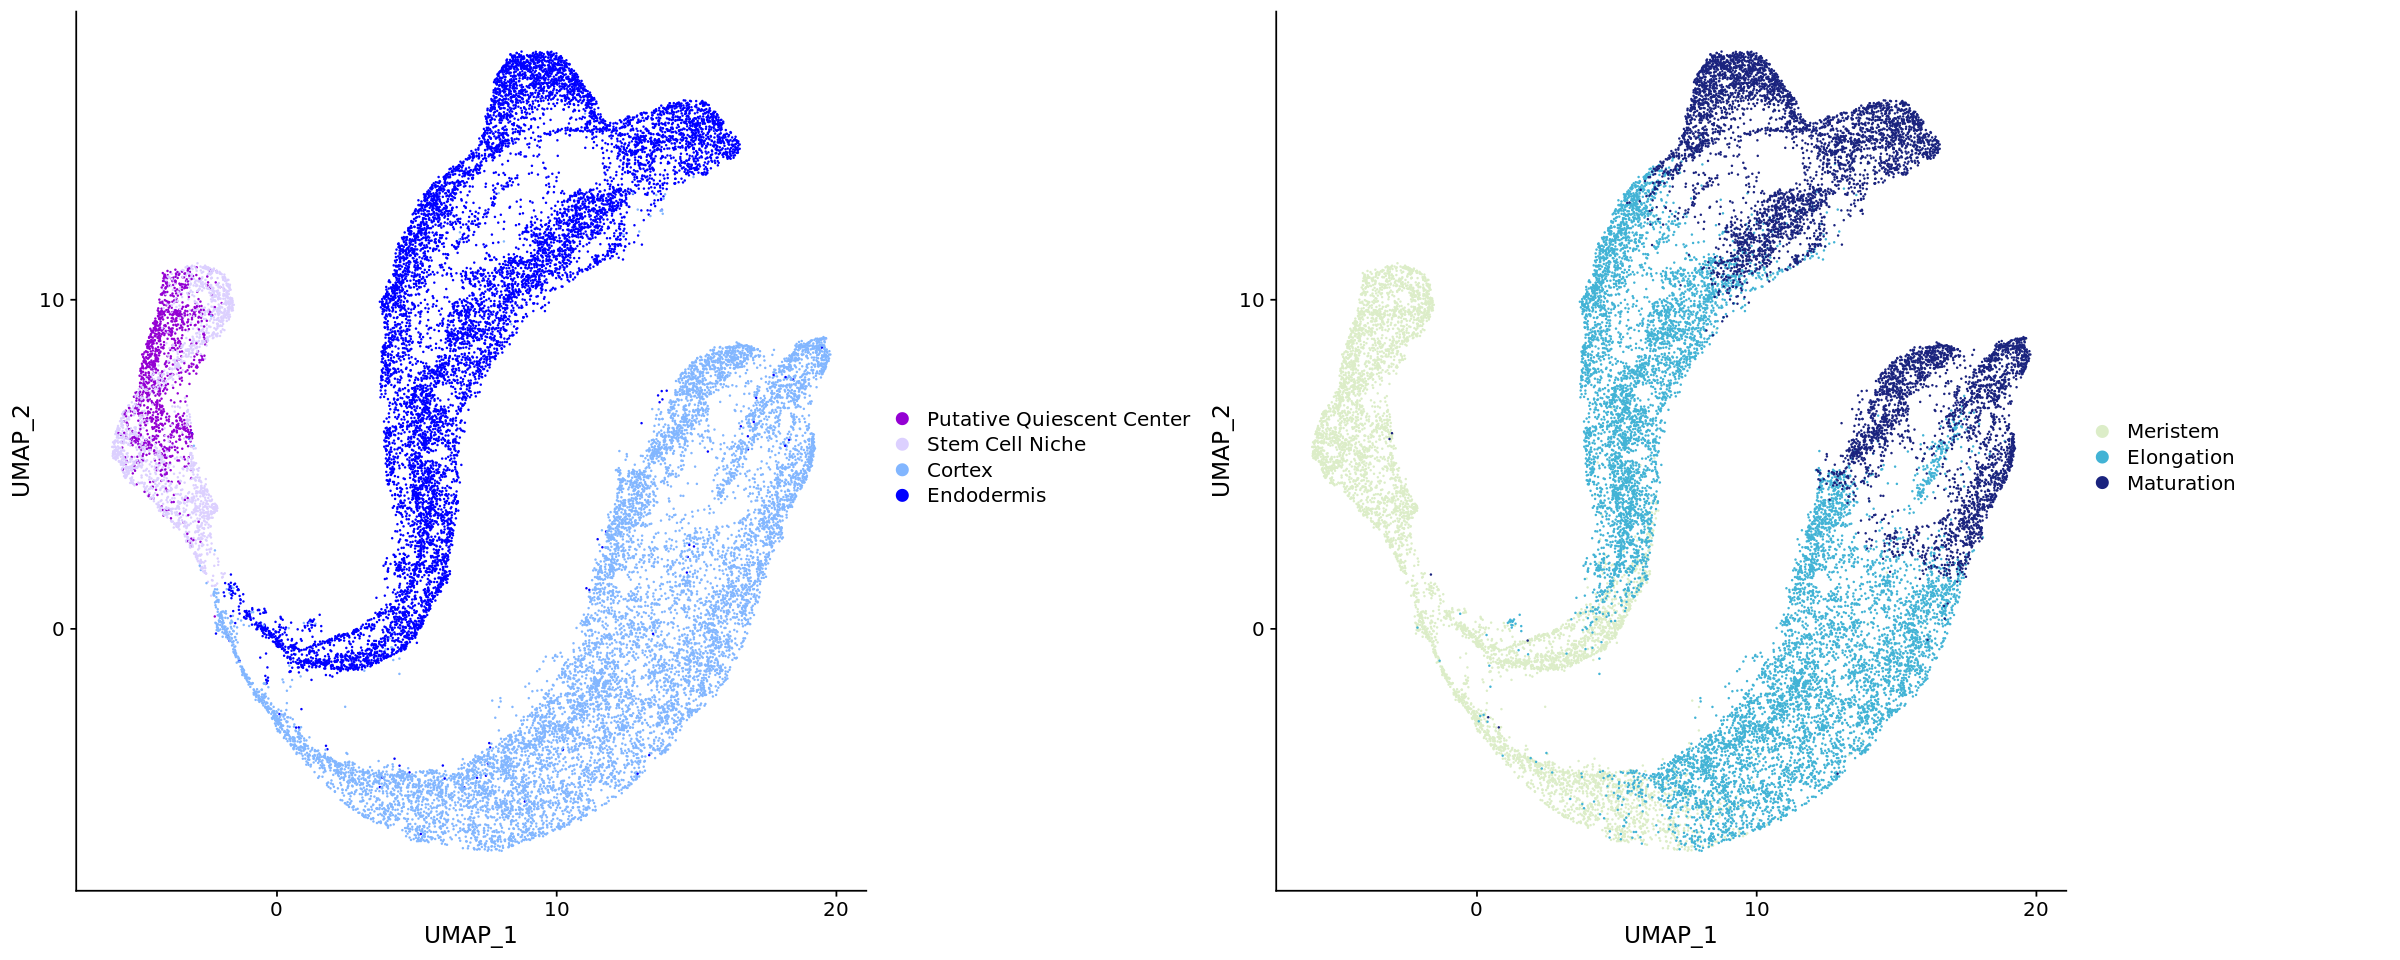

In [12]:
plot_anno(end.cor.integrated)

In [18]:
# Prepare expression matrix for CytoTRACE
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [19]:
# Run CytoTRACE
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE 

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 24 sub-sample(s) of approximately 987 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [13]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



In [14]:
# Save Seurat object
saveRDS(end.cor.integrated,'./supp_data/Ground_Tissue_Atlas.rds')

In [15]:
# Prepare scVelo input
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("time.anno|celltype.anno|time.celltype.anno|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Ground_Tissue_Atlas_scVelo_input.RData")

## 2. Extract Epidermis + LRC

In [8]:
# Index for epidermis + LRC trajectory
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Putative Quiescent Center" | rc.integrated$celltype.anno == "Stem Cell Niche" | rc.integrated$celltype.anno == "Atrichoblast" | rc.integrated$celltype.anno == "Trichoblast" | rc.integrated$celltype.anno == "Lateral Root Cap" );
# Extract epidermis + LRC
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])
# Run UMAP
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 50)
end.cor.integrated@reductions$umap_50 <- end.cor.integrated@reductions$umap
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
end.cor.integrated@reductions$umap_2D <- end.cor.integrated@reductions$umap
end.cor.integrated <- FindNeighbors(end.cor.integrated, reduction = "umap_50",dims = 1:50)
plot_anno(end.cor.integrated)

Computing nearest neighbor graph

Computing SNN



In [9]:
# Prepare expression matrix for CytoTRACE
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [10]:
# Run CytoTRACE
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE 

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 42 sub-sample(s) of approximately 994 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [11]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



In [14]:
saveRDS(end.cor.integrated,'./supp_data/Epidermis_LRC_Atlas.rds')

In [15]:
# Prepare scVelo input
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
#int[which(int < 0)]=0
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("time.anno|celltype.anno|time.celltype.anno|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Epidermis_LRC_Atlas_scVelo_input.RData")

## 3. Extract Columella

Computing nearest neighbor graph

Computing SNN



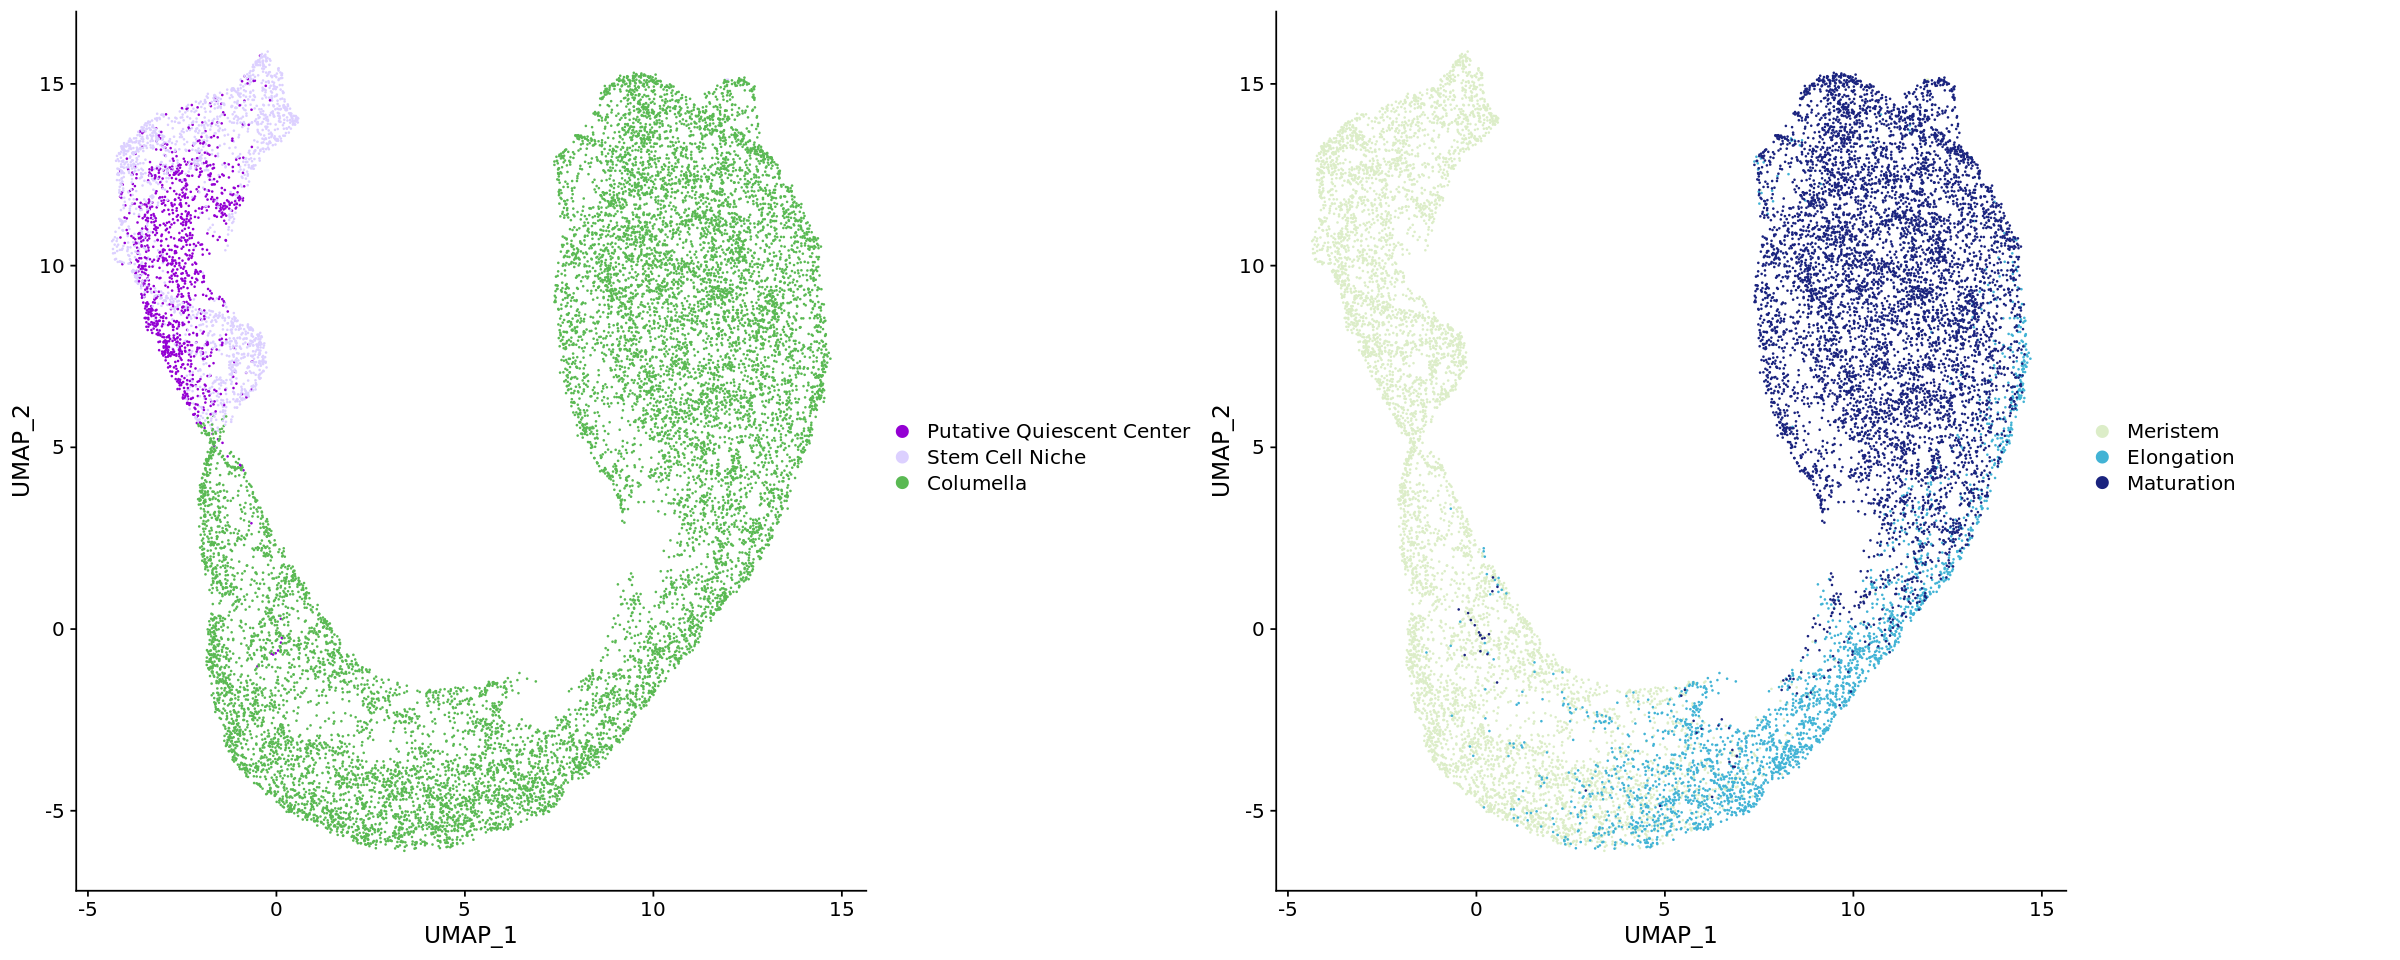

In [16]:
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Putative Quiescent Center" | rc.integrated$celltype.anno == "Columella" | rc.integrated$celltype.anno == "Stem Cell Niche" );
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 50)
end.cor.integrated@reductions$umap_50 <- end.cor.integrated@reductions$umap
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
end.cor.integrated@reductions$umap_2D <- end.cor.integrated@reductions$umap
end.cor.integrated <- FindNeighbors(end.cor.integrated, reduction = "umap_50",dims = 1:50)
plot_anno(end.cor.integrated)

In [17]:
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [18]:
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 16 sub-sample(s) of approximately 990 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Warning message in CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), :
“2 poor quality cells were filtered based on low or no expression. See 'filteredCells' in returned object for names of filtered cells.”
Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



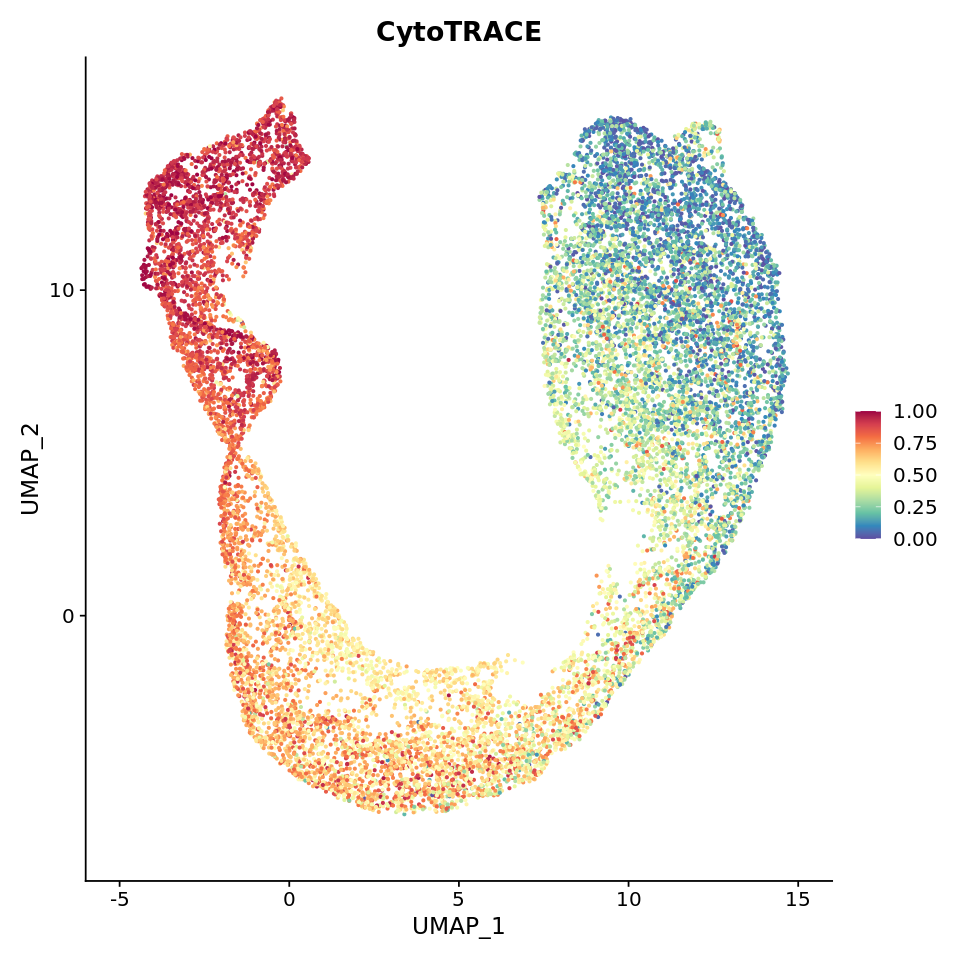

In [19]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

In [22]:
saveRDS(end.cor.integrated,'./supp_data/Columella_Atlas.rds')

In [23]:
# Prepare scVelo input
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
#int[which(int < 0)]=0
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("timezone.ID.P|Long.ID.P|final.anno.wo.unknown|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Columella_Atlas_scVelo_input.RData")

## 4. Extract Stele

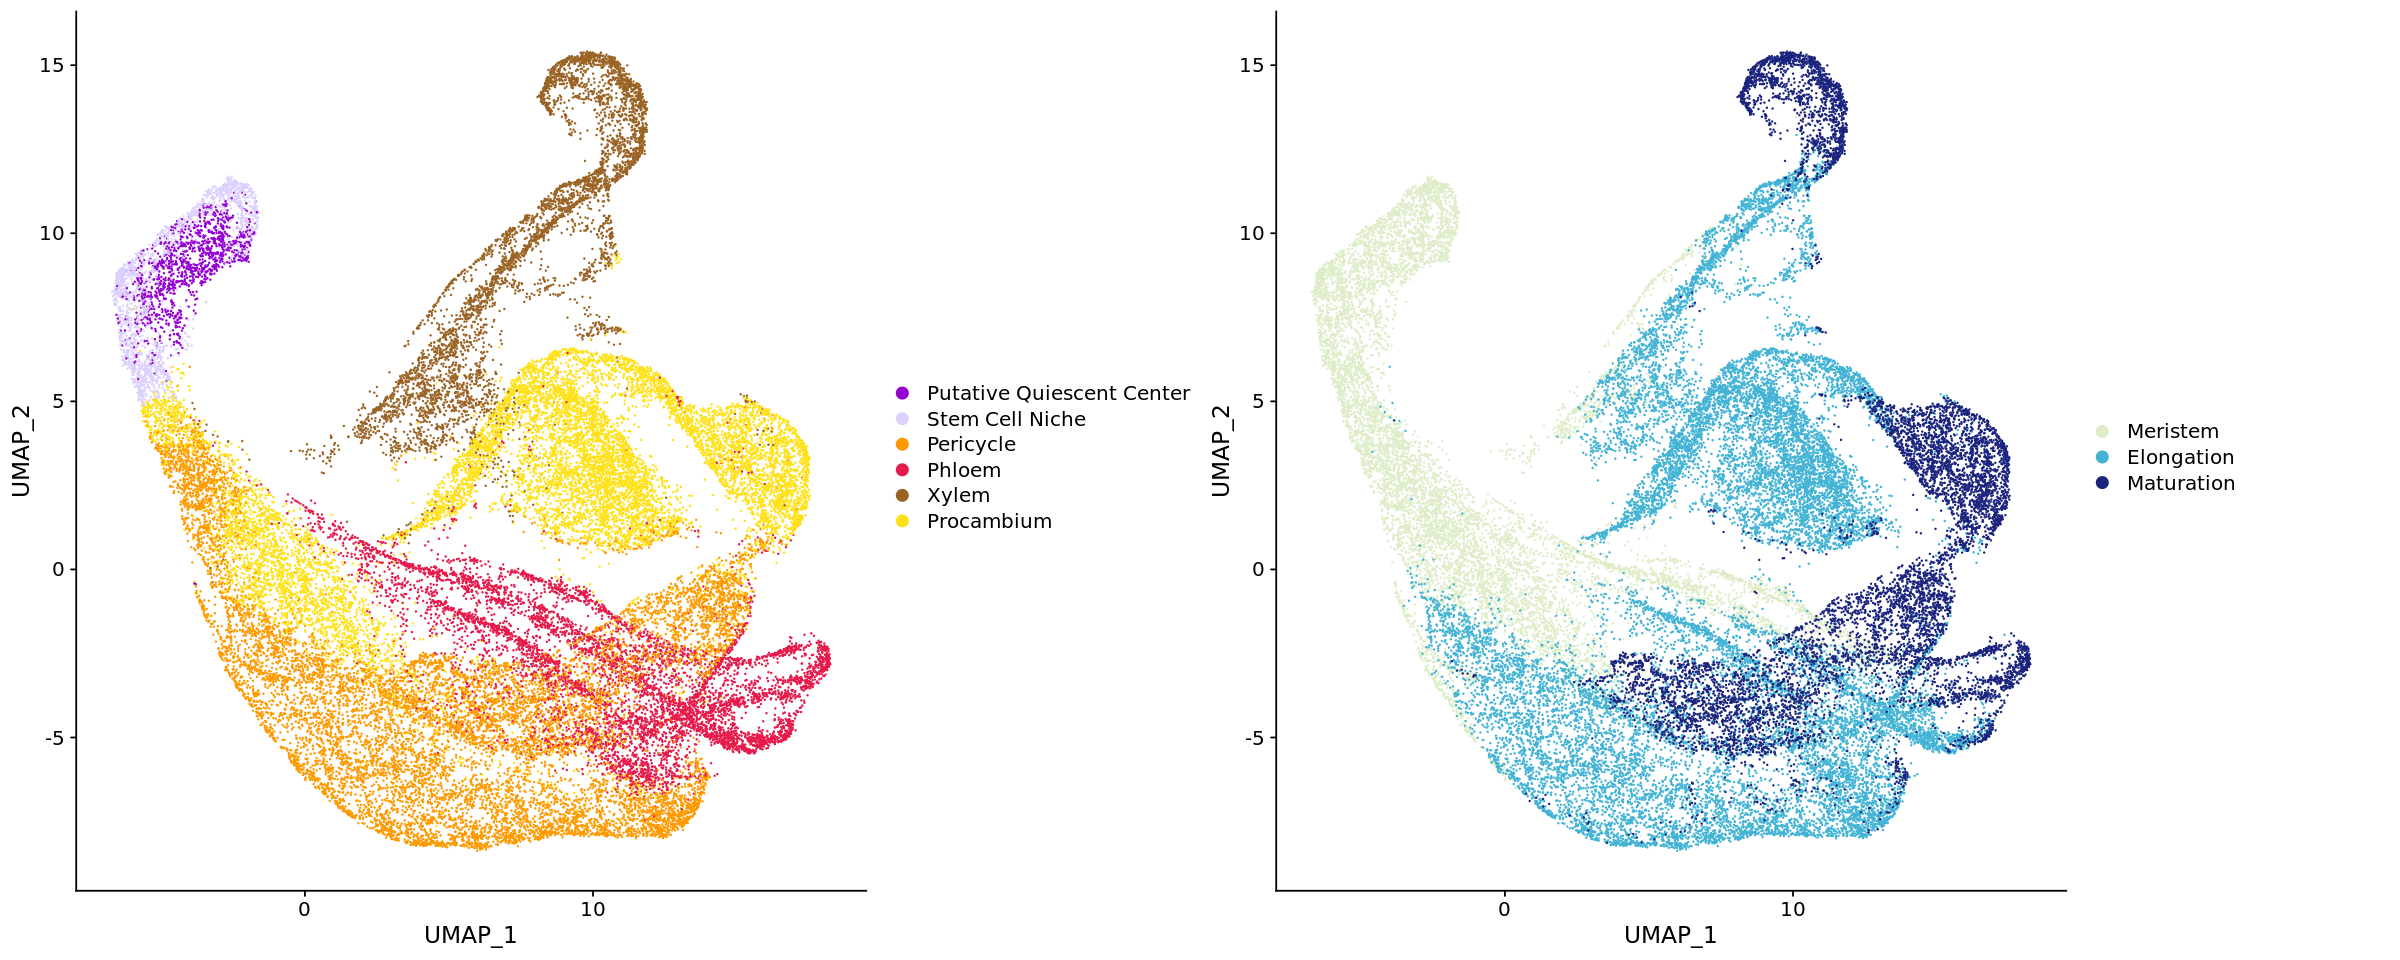

In [39]:
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Pericycle" | rc.integrated$celltype.anno == "Phloem" | rc.integrated$celltype.anno == "Xylem" | rc.integrated$celltype.anno == "Procambium" | rc.integrated$celltype.anno == "Putative Quiescent Center"| rc.integrated$celltype.anno == "Stem Cell Niche");
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 50)
end.cor.integrated@reductions$umap_50 <- end.cor.integrated@reductions$umap
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
end.cor.integrated@reductions$umap_2D <- end.cor.integrated@reductions$umap
end.cor.integrated <- FindNeighbors(end.cor.integrated, reduction = "umap_50",dims = 1:50)
plot_anno(end.cor.integrated)

In [16]:
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [20]:
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 38 sub-sample(s) of approximately 1004 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



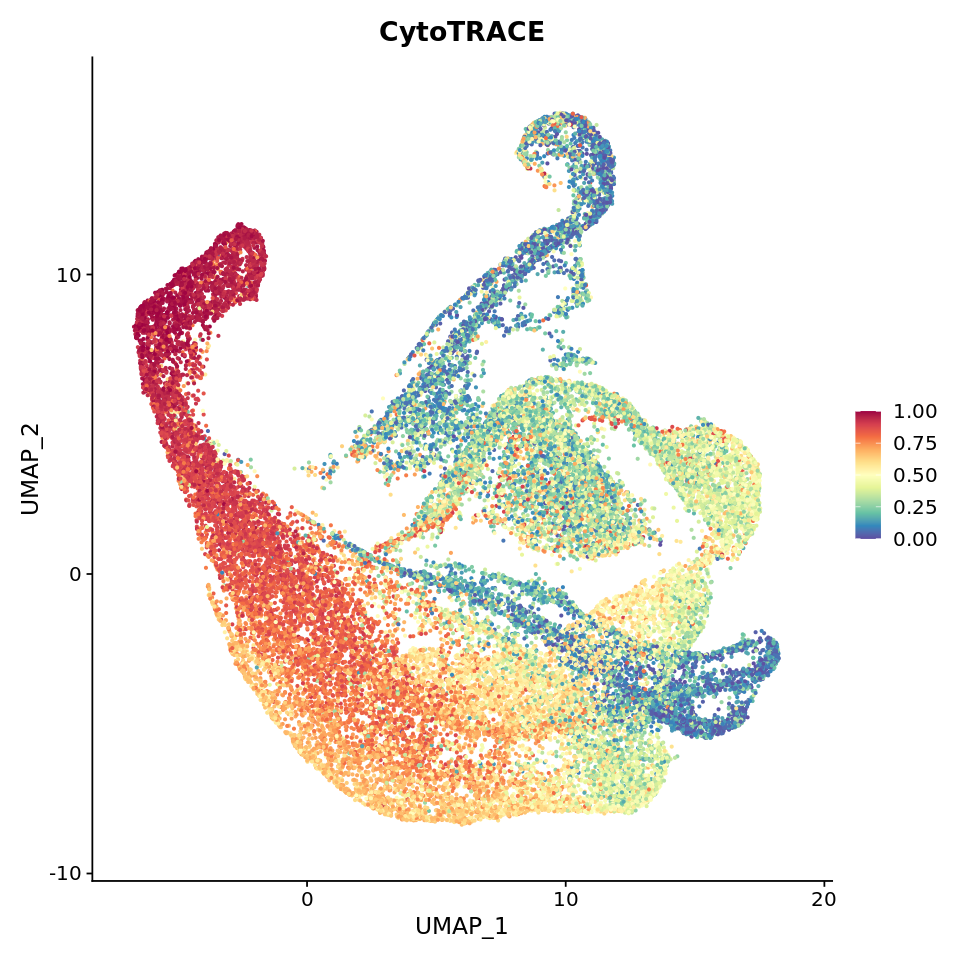

In [21]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

In [38]:
saveRDS(end.cor.integrated,'./supp_data/Stele_Atlas.rds')

In [22]:
# Prepare scVelo input
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
#int[which(int < 0)]=0
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("timezone.ID.P|Long.ID.P|final.anno.wo.unknown|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Stele_Atlas_scVelo_input.RData")